# Abalone Data Clustering & Classification by Sex

Names: Trevor Chessnoe, Miguel Llanes, Olivia Schafer <br>
Version 1.0 Completed: 11-11-2024 <br>
**Last updated**: 12-18-2025
Project 1: Group 6 <br>

Dataset link: https://archive.ics.uci.edu/dataset/1/abalone

# 0. Global Constants

In [16]:
seed = 0

# 1. Data Overview

## a. Import and Select Data

In [17]:
import pandas as pd
import numpy as np
import os

# Seed random state for numpy funcs
np.random.seed(seed)
# Import data from file
os.makedirs('/content/data', exist_ok=True)
df = pd.read_csv('data/abalone.data')
# Add column names
df.columns = ['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings']
# Create category labels for graphs later
category_labels = ['Male','Female','Infant']
# Show layout of dataframe
df.head(5)

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
1,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
2,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
3,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7
4,I,0.425,0.300,0.095,0.3515,0.1410,0.0775,0.120,8


## b. Data Overview

In [18]:
print(f"Num of records: {df.shape[0]}")
print(f"Num of features: {df.shape[1]}")
features = df.columns.to_list()
print(f"Data features: {features}\n")

# Remove features that cannot be averaged
means_df = df.drop(columns='Sex')

# Show avgs for abalone features
abalone_means = pd.DataFrame(means_df.mean())
abalone_means.columns = ['Mean Values']

print(abalone_means)

Num of records: 4176
Num of features: 9
Data features: ['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings']

                Mean Values
Length             0.524009
Diameter           0.407892
Height             0.139527
Whole weight       0.828818
Shucked weight     0.359400
Viscera weight     0.180613
Shell weight       0.238852
Rings              9.932471


## c. Sex distribution of Abalone

Male: 1307
Female: 1342
Infant: 1527


/tmp/ipython-input-1807479838.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(pie_labels[i]+": "+str(sex_counts[i]))


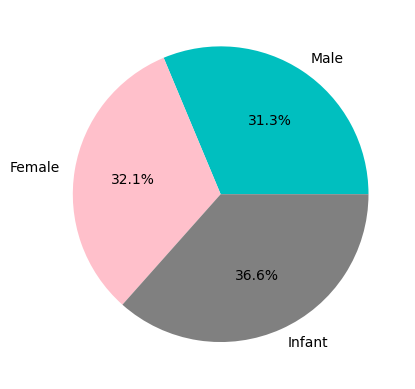

In [63]:
import matplotlib.pyplot as plt

# 1. Organize values for charting
sex_counts = df['Sex'].value_counts().sort_index()
pie_labels = category_labels
colors = ['c','pink','0.5']

# 2. Print label counts
for i in range(0,3):
  print(pie_labels[i]+": "+str(sex_counts[i]))

# 3. Plot & save pie chart
os.makedirs('/content/graphs', exist_ok=True) # Create output dir for graphs
plt.pie(sex_counts, labels=pie_labels, colors=colors, autopct='%1.1f%%')
plt.savefig("graphs/sex-pie.png")

# 2. Clustering

## a. Separate Labels from Data Vector

In [20]:
data = df.drop(columns='Sex')
# Create labels vector to filter plot data later
labels = df['Sex']

## b. Preprocess data for graphing: Scaling & PCA

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 1. Normalize value ranges for features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# 2. Project 9-D Abalone data to 2-D space for graphing
pca = PCA(n_components=2)
proj_data = pca.fit_transform(data_scaled)

# Verify that dataset has been decomposed via PCA
print(pd.DataFrame(proj_data).head(5))
print("\n")

# 3. Output EV to measure data loss from decompostion
print(f"Explained Variance = {pca.explained_variance_ratio_[0]:.2%}")

          0         1
0 -3.483808 -0.092029
1 -0.536489 -0.048832
2 -1.458203  0.419349
3 -3.767037 -0.065034
4 -2.608167  0.024552


Explained Variance = 83.91%


Our values for explained variance are around 84%. Therefore the 2D projection of the dataset maintains 84% of the variance present in the original abalone dataset. This is excellent and suggests that our visualizations using the projected data will accurately reflect the characteristics of the actual dataset.

## c. Determine Optimal Cluster No. Using Elbow Method

### i. Define Required Functions

In [22]:
import math

def calc_optimal_k(x_pts, y_pts, m, b):
  # 1. Init variables used by func
  x1, y1 = x_pts[0], y_pts[0]
  x2, y2 = x_pts[-1], y_pts[-1]
  max_dist = 0
  max_x = 0

  # Calculate dist between pt on elbow graph & endpoint line
  # Effectively finds point of diminishing returns
  for i in range(0, len(x_pts)):
    # calc dist between points
    data_point = x_pts[i], y_pts[i]
    elbow_seg_y = m * x_pts[i] + b
    elbow_seg_pt = (x_pts[i], elbow_seg_y)
    dist = math.dist(elbow_seg_pt, data_point)

    # TEST CODE: Verify correct dist calculations
    print(f"For k={i+1}:")
    print(f"\t ({x_pts[i]},{round(y_pts[i],1)}) -> ({x_pts[i]},{round(elbow_seg_y,1)})")
    print(f"\t d={dist}\n")

    # Return k-val that maxes dist
    if dist > max_dist:
      max_dist = dist
      max_x = x_pts[i]

  optimal_k = max_x
  return optimal_k



### ii. Plot Elbow Graph

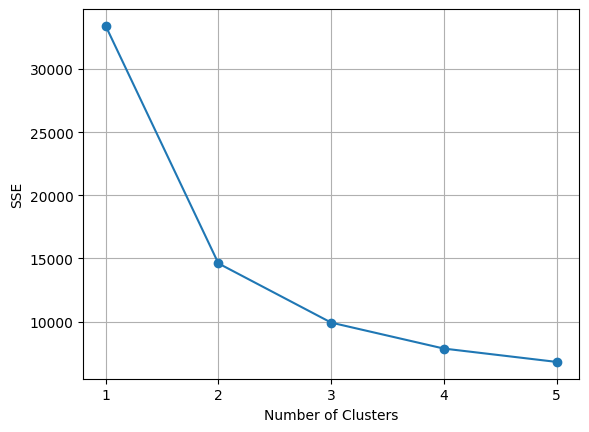

In [23]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.cluster import KMeans

SSE = []
start_k = 1
end_k = 5

# 1. Find SSE for each cluster no.
for k in range(start_k, end_k+1):
    k_means = KMeans(n_clusters = k)
    k_means.fit(data_scaled)
    SSE.append(k_means.inertia_)

# 2. Plot Elbow chart
plt.plot(range(1, 6), SSE, marker='o')

# 3. Set graph properties
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.grid(True)

# 4. Format x axis to hide decimal values
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

os.makedirs('/content/graphs', exist_ok=True) # Here in case this is run independently of sec 1
plt.savefig("graphs/elbow-chart.png")

### iii. Calculate Optimal K-value

In [24]:
import numpy as np
# 1. Get elbow x & y pts to calc optimal k
x_pts = [x for x in range(1,6)]
y_pts = SSE

# 2. Get line seg coeffs to calc optimal k
seg_x_pts = [x_pts[0], x_pts[-1]]
seg_y_pts = [SSE[0], SSE[-1]]
# Find line between elbow graph endpoints
coeffs = np.polyfit(seg_x_pts, seg_y_pts, 1)
m = coeffs[0]
b = coeffs[1]

# 3. Calc optimal k, disp result
optimal_k= calc_optimal_k(x_pts, y_pts, m, b)
print(f"The optimal number of clusters is k={optimal_k}.")

For k=1:
	 (1,33408.0) -> (1,33408.0)
	 d=7.275957614183426e-12

For k=2:
	 (2,14607.3) -> (2,26758.3)
	 d=12150.934245946573

For k=3:
	 (3,9921.1) -> (3,20108.5)
	 d=10187.408414535144

For k=4:
	 (4,7865.4) -> (4,13458.8)
	 d=5593.393602295516

For k=5:
	 (5,6809.0) -> (5,6809.0)
	 d=1.7280399333685637e-11

The optimal number of clusters is k=2.


### iv. Plot Elbow chart with Optimal K-value

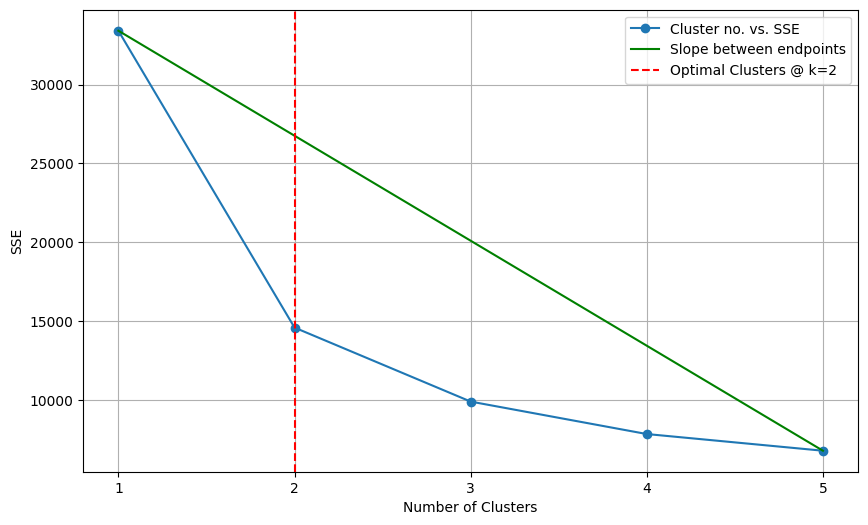

In [25]:
plt.figure(figsize=(10,6))

# 1. Plot Elbow chart
plt.plot(range(1, 6), SSE, marker='o', label='Cluster no. vs. SSE')

# 2. Plot top Line Segment for distance analysis
plt.plot(seg_x_pts, seg_y_pts, color='green', label='Slope between endpoints')

# 3. Plot Vert. line at optimal k
plt.axvline(x=optimal_k, color='red', linestyle='--', label=f'Optimal Clusters @ k={optimal_k}')

# 4. Set graph properties
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.legend()
plt.grid(True)

# Format x axis to hide decimal values
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
# 5. Save chart in graphs folder
plt.savefig("graphs/elbow+optimal_k-chart.png")

## d. Compare K-means Clustering Performance for k = 2, 3

We chose to test the model with 2 & 3 clusters for 2 reasons:
1. These values were the furthest from the endpoint line, and thus were candidates for the point of diminishing returns
2. Reflects split between Infants vs. Adults & Males vs. Females vs. Infants

### i. Compare Silhouette Scores for Both K-values

In [26]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# 1. Fit data & assign clusters for k=2
kmeans = KMeans(n_clusters=2)
kmeans.fit(data_scaled)
k2_lbl = kmeans.labels_

# 2. Calculate silhouette score k=2
silhouette = silhouette_score(data_scaled, k2_lbl)
print("k=2 Silhouette Score = ", silhouette)

# 3. Fit data & assign clusters for k=3
kmeans = KMeans(n_clusters=3)
kmeans.fit(data_scaled)
k3_lbl = kmeans.labels_

# 4. Calculate silhouette score k=3
silhouette = silhouette_score(data_scaled, k3_lbl)
print("k=3 Silhouette Score = ", silhouette)

k=2 Silhouette Score =  0.4694235157041028
k=3 Silhouette Score =  0.38477880914689094


A. Explaining Silhouette Score
Silouhette Scores measure the ratio of **cohesion** (how close together data points are in the same cluster) to **separation** (how far data points are from their nearest neighbor cluster). A high silhouette score (close to 1) indicates excellent clustering, where on average, data points lie withint their own cluster and far from all other clusters. A low silhouette (close to -1) shows that most points are closer another cluster than their own.

B. Interpreting Our Silhouette Scores
The 2-cluster model has a silhouette score close to 0.5, indicating fair clustering performance. The 3-cluster model still has significantly worse clustering performance at ~0.385, but is still far from a score of 0, which would indicate borderline clustering performance.


## e. Visualize Clustering Performance for K-Means

### i. Prepare Data for Graphing

In [38]:
import numpy as np
# 1. Assign 2D projections of data to X and y
X = proj_data[:,0]
y = proj_data[:,1]

# 2. Sample 1/3 of all data points to reduce graph crowding

# a. Get rand indices to select elems from relevant arrays
full_size = len(X)
sample_size = len(X) // 5
sampled_indices = np.random.choice(full_size, sample_size, replace=False)

# b. Sample proj data points
X_s = X[sampled_indices]
y_s = y[sampled_indices]

# c. Sample k=2 and k=3 cluster labels
k2_lbl_s = k2_lbl[sampled_indices]
k3_lbl_s = k3_lbl[sampled_indices]

# d. Sample labels vector for point coloration
labels_s = labels[sampled_indices]

# 3. Set point properties for all scatter plots
p_size = 12
ec = 'black'

### ii. Graph Cluster Assignments for (k=2)

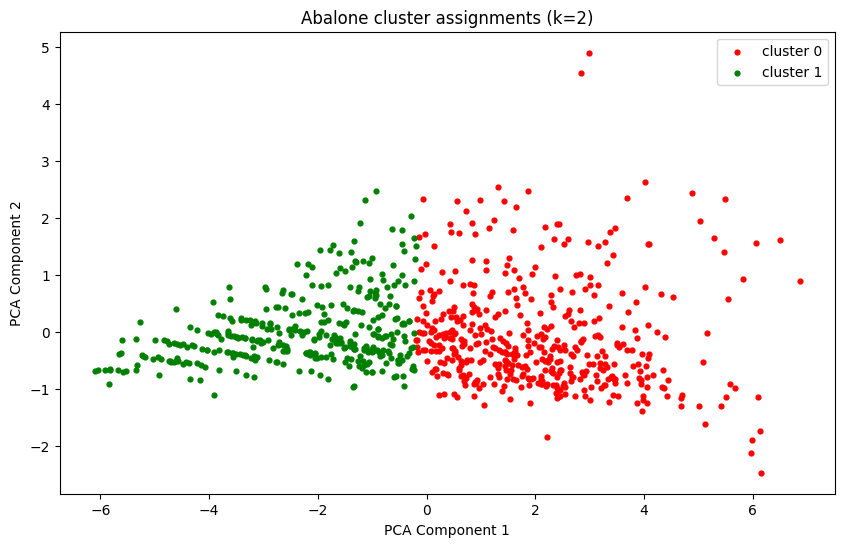

In [47]:
# Set graph properties
plt.figure(figsize=(10, 6))
plt.title("Abalone cluster assignments (k=2)")
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

# Plot projected data with colors for cluster assignments
plt.scatter(X_s[k2_lbl_s == 0], y_s[k2_lbl_s == 0], color='r', s=p_size, label='cluster 0')
plt.scatter(X_s[k2_lbl_s == 1], y_s[k2_lbl_s == 1], color='g', s=p_size, label='cluster 1')
plt.legend()
# Fig must be saved to system b4 plt.show
plt.savefig("graphs/2NN-cluster-plot.png")
plt.show()

### ii. Graph True Labels by Age

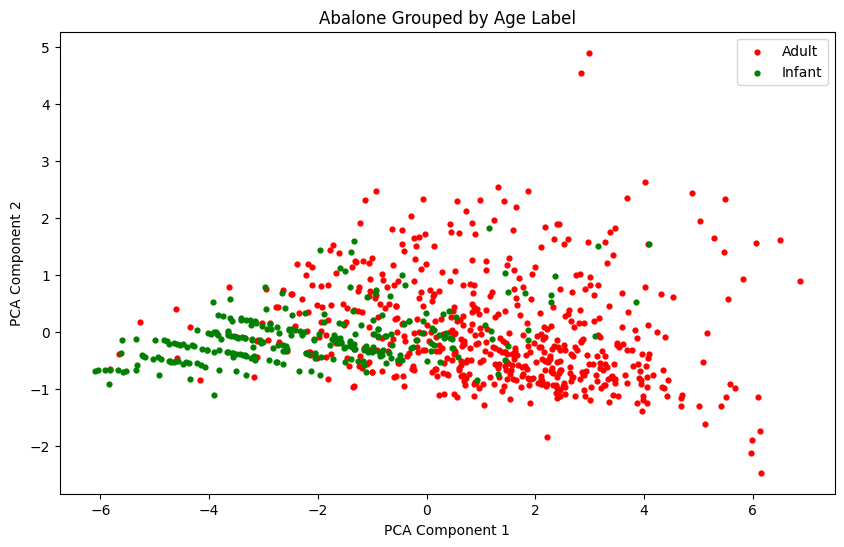

In [48]:
# 1. Set graph properties
plt.figure(figsize=(10, 6))
plt.title("Abalone Grouped by Age Label")
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

# 2. Combine Female and Male data pts into adults array
X_male, y_male = X_s[labels_s=='M'], y_s[labels_s=='M']
X_female, y_female = X_s[labels_s=='F'], y_s[labels_s=='F']
X_adult = np.concatenate((X_male, X_female))
y_adult = np.concatenate((y_male, y_female))

# 3. Infant data is already seprately labeled
X_infant, y_infant = X_s[labels_s=='I'], y_s[labels_s=='I']

# 4. Plot proj data for adults and infants with colored points
plt.scatter(X_adult, y_adult, color='r', s=p_size, label='Adult')
plt.scatter(X_infant, y_infant, color='g', s=p_size, label='Infant')
plt.legend()
plt.savefig("graphs/age-scatter-plot.png")
plt.show()

### iii. Graph Cluster Assignments for (k=3)

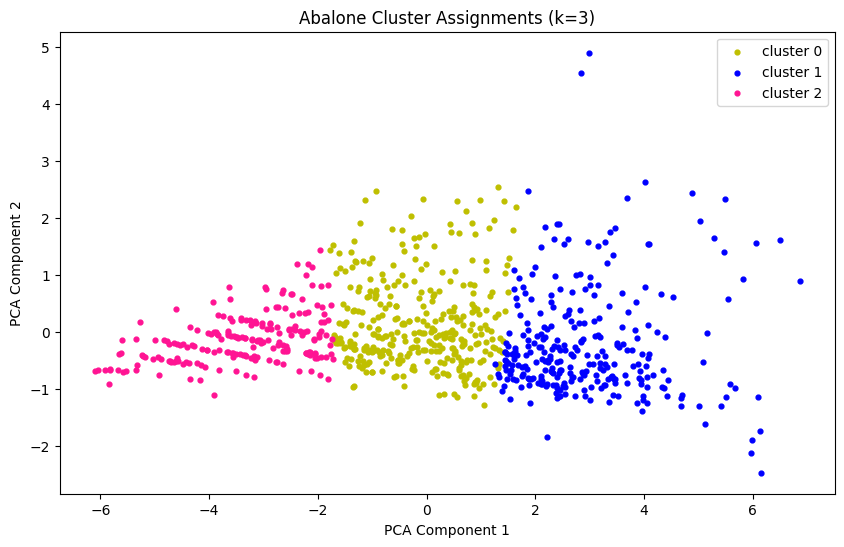

In [51]:
# 1. Set graph properties
plt.figure(figsize=(10, 6))
plt.title("Abalone Cluster Assignments (k=3)")
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

# 2. Plot proj data with colors for cluster assignments
plt.scatter(X_s[k3_lbl_s == 0], y_s[k3_lbl_s == 0], color='y', s=p_size, label='cluster 0')
plt.scatter(X_s[k3_lbl_s == 1], y_s[k3_lbl_s == 1], color='b', s=p_size, label='cluster 1')
plt.scatter(X_s[k3_lbl_s == 2], y_s[k3_lbl_s == 2], color='deeppink', s=p_size, label='cluster 2')
plt.legend()
plt.savefig("graphs/3NN-cluster-plot.png")
plt.show()

### iv. Graph True Labels by Sex

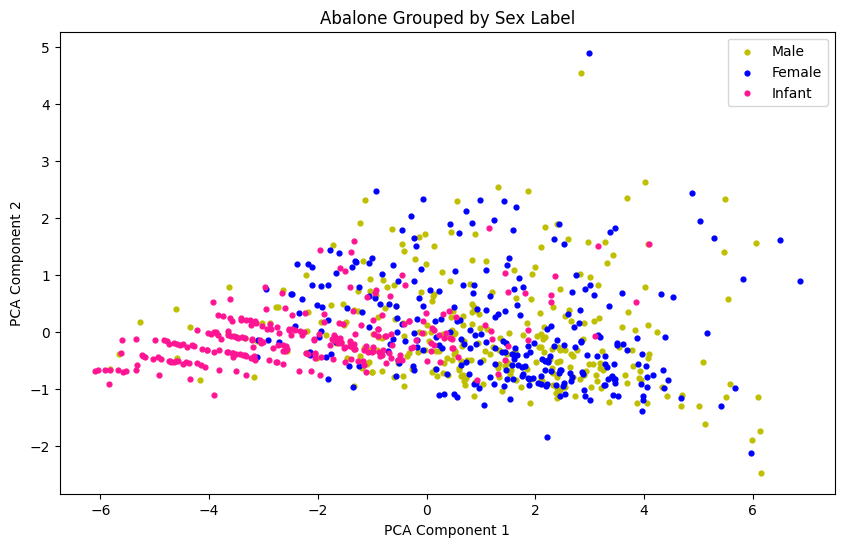

In [64]:
# Set graph properties
plt.figure(figsize=(10, 6))
plt.title("Abalone Grouped by Sex Label")
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

# Plot abalone data points with colors assigned by sex
plt.scatter(X_male, y_male, color='y', s=p_size, label='Male')
plt.scatter(X_female, y_female, color='b', s=p_size, label='Female')
plt.scatter(X_infant, y_infant, color='deeppink', s=p_size, label='Infant')
plt.legend()
plt.savefig("graphs/sex-scatter-plot.png")
plt.show()

Summary:
Using a K-means model with 2 clusters, we were able to create fairly-well defined clusters that somewhat accurately reflect the divide in the data between adult (male & female) and infant abalone specimens. So far it seems like these 9 features are good predictors of age, but not sex, since the 3-cluster model had less well-defined clusters and cluster assignment did not reflect the distribution of sex among the abalone specimens.

# 3. Classification

## a. Create Separate Datasets for Age & sex Modeling

In [54]:
# 1. Change Sex column to labels to prepare for split by age & sex
labeled_data = df.rename(columns={'Sex':'labels'})
sex_data  = labeled_data.copy()
age_data = labeled_data.copy()

# 2. Replace male & female labels with adult in age data
age_data.loc[age_data['labels']=='M', 'labels'] = 'A'
age_data.loc[age_data['labels']=='F', 'labels'] = 'A'

# 3. Verify that labels have been properly assigned
print(age_data['labels'].head(5))
print(sex_data['labels'].head(5))

0    A
1    A
2    A
3    I
4    I
Name: labels, dtype: object
0    M
1    F
2    M
3    I
4    I
Name: labels, dtype: object


## b. Normalize Features for Both Datasets

In [55]:
from sklearn.preprocessing import StandardScaler

# 1. Separate labels from data before scaling features
age_labels = age_data['labels']
sex_labels = sex_data['labels']

# 2. Normalize value ranges for numeric features
scaler = StandardScaler()
age_scaled = scaler.fit_transform(age_data.drop(columns='labels'))
sex_scaled = scaler.fit_transform(sex_data.drop(columns='labels'))

## c. Perform Train-Test Split

In [56]:
from sklearn.model_selection import train_test_split

test_size = 0.2

X_train_age, X_test_age, y_train_age, y_test_age = train_test_split(age_scaled,
                                                    age_labels,
                                                    test_size=test_size,
                                                    random_state=seed)

X_train_sex, X_test_sex, y_train_sex, y_test_sex = train_test_split(sex_scaled,
                                                    sex_labels,
                                                    test_size=test_size,
                                                    random_state=seed)

## d. Train MLP Classifier & Make Predictions

In [57]:
from sklearn.neural_network import MLPClassifier

# 1. Set up Classifier for Age Prediction

# Initialize MLP classifier
mlp = MLPClassifier(hidden_layer_sizes=(100, 70, 50, 30), activation='relu', max_iter=1000, alpha=0.0001, random_state=seed)
# Train the classifier
mlp.fit(X_train_age, y_train_age)
# Make predictions on the test set
age_pred = mlp.predict(X_test_age)

# 2. Set up Classifier for Sex Prediction

# Initialize MLP classifier
mlp = MLPClassifier(hidden_layer_sizes=(100, 70, 50, 30), activation='relu', max_iter=1000, alpha=0.0001, random_state=seed)
# Train the classifier
mlp.fit(X_train_sex, y_train_sex)
# Make predictions on the test set
sex_pred = mlp.predict(X_test_age)

## e. Evaluate Models with Classification metrics

### i. Define Helper Function

In [58]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

def print_clf_metrics(y_test, y_pred):
  print(f"\tAccuracy = {accuracy_score(y_test, y_pred):.2%}" )
  print(f"\tPrecision Score: {precision_score(y_test, y_pred, average = 'macro'):.2%}" )
  print(f"\tRecall Score: {recall_score(y_test, y_pred, average = 'macro'):.2%}", )
  print(f"\tF1 Score: {f1_score(y_test, y_pred, average = 'macro'):.2%}\n")

### ii. Evaluate Classification Performance

In [59]:
print("Age Data Classification Performance: ")
print_clf_metrics(y_test_age, age_pred)

print("Sex Data Classification Performance: ")
print_clf_metrics(y_test_sex, sex_pred)

Age Data Classification Performance: 
	Accuracy = 80.14%
	Precision Score: 78.12%
	Recall Score: 78.79%
	F1 Score: 78.42%

Sex Data Classification Performance: 
	Accuracy = 52.99%
	Precision Score: 52.32%
	Recall Score: 52.86%
	F1 Score: 52.27%



## f. Confusion Matrices

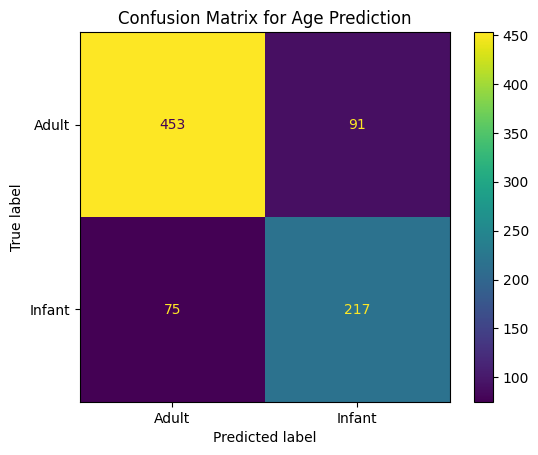

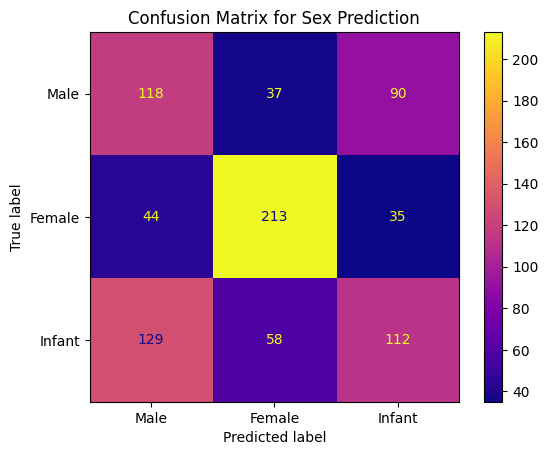

In [60]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# 0. Create output dir for CMs
os.makedirs('/content/cm', exist_ok=True)

# 1. Create category labels for CMs
age_cats = ['Adult', 'Infant']
sex_cats = ['Male','Female','Infant']

# 2. Create & disp CM for age data
age_cm = confusion_matrix(y_test_age, age_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=age_cm, display_labels=age_cats)
disp.plot()
disp.ax_.set_title("Confusion Matrix for Age Prediction")
# Save cms to system as pngs
plt.savefig("cm/age-cm.png")
plt.show()

# 3. Create & disp CM for sex data
sex_cm = confusion_matrix(y_test_sex, sex_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=sex_cm, display_labels=sex_cats)
disp.plot(cmap='plasma')
disp.ax_.set_title("Confusion Matrix for Sex Prediction")
plt.savefig("cm/sex-cm.png")
plt.show()

# Download all generated graphs and confusion matrices

In [61]:
# Zip the 'graphs' and 'cm' folders
!zip -r /content/analysis_results.zip /content/graphs /content/cm

# Create a link to download the zip file
from google.colab import files
files.download('/content/analysis_results.zip')

  adding: content/graphs/ (stored 0%)
  adding: content/graphs/elbow-chart.png (deflated 11%)
  adding: content/graphs/age-scatter-plot.png (deflated 7%)
  adding: content/graphs/sex-pie.png (deflated 17%)
  adding: content/graphs/3NN-cluster-plot.png (deflated 8%)
  adding: content/graphs/elbow+optimal_k-chart.png (deflated 8%)
  adding: content/graphs/sex-scatter-plot.png (deflated 6%)
  adding: content/graphs/2NN-cluster-plot.png (deflated 8%)
  adding: content/cm/ (stored 0%)
  adding: content/cm/age-cm.png (deflated 14%)
  adding: content/cm/sex-cm.png (deflated 12%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Future Updates
* Consider adding silhouette plots
